In [1]:
import tqdm
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# PyTorch
import torch
import torchvision

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import losses
import utils

In [3]:
n = 100
random_state = 1001
encoded_path = f'/cluster/tufts/hugheslab/eharve06/understanding-SNGP/data/CIFAR-10_n={n}_random_state={random_state}.npz'
data = np.load(encoded_path)
X_train = torch.tensor(data['X_train'], dtype=torch.float32)
y_train = torch.tensor(data['y_train'], dtype=torch.long)
X_val = torch.tensor(data['X_val'], dtype=torch.float32)
y_val = torch.tensor(data['y_val'], dtype=torch.long)
X_train_and_val = torch.cat((X_train, X_val), dim=0)
y_train_and_val = torch.cat((y_train, y_val), dim=0)
X_test = torch.tensor(data['X_test'], dtype=torch.float32)
y_test = torch.tensor(data['y_test'], dtype=torch.long)

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
train_and_val_dataset = torch.utils.data.TensorDataset(X_train_and_val, y_train_and_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

In [5]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=min(batch_size, len(train_dataset)), shuffle=True, drop_last=True)
train_and_val_loader = torch.utils.data.DataLoader(train_and_val_dataset, batch_size=min(batch_size, len(train_dataset)), shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

In [13]:
lr_0 = 1e-2
model = torch.nn.Module()
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
model = layers.VariationalLinear(torch.nn.Linear(in_features=2048, out_features=10, bias=True), model.sigma_param)

d = len(utils.flatten_params(model))
criterion = losses.DataEmphasizedELBo(d/len(train_dataset), model.sigma_param, criterion=torch.nn.CrossEntropyLoss())
optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.0, lr=lr_0, momentum=0.9, nesterov=True)

steps = 6000
num_batches = len(train_loader)
epochs = int(steps/num_batches)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*num_batches)

columns = ['epoch', 'train_acc', 'train_loss', 'train_nll', 'test_acc', 'test_loss', 'test_nll', 'val_acc', 'val_loss', 'val_nll']
model_history_df = pd.DataFrame(columns=columns)

for epoch in tqdm.tqdm(range(epochs)):
    train_metrics = utils.train_one_epoch(model, criterion, optimizer, train_and_val_loader, scheduler)
    #train_metrics = utils.train_one_epoch(model, criterion, optimizer, train_loader)
    val_metrics = {'acc': 0.0, 'loss': 0.0, 'nll': 0.0}
    test_metrics = {'acc': 0.0, 'loss': 0.0, 'nll': 0.0}

    if epoch == epochs-1:
        test_metrics = utils.evaluate(model, criterion, test_loader)
        val_metrics = utils.evaluate(model, criterion, val_loader)

    row = [epoch, train_metrics['acc'], train_metrics['loss'], train_metrics['nll'], test_metrics['acc'], test_metrics['loss'], test_metrics['nll'], val_metrics['acc'], val_metrics['loss'], val_metrics['nll']]
    model_history_df.loc[epoch] = row
    #print(model_history_df.iloc[epoch])
    

100%|██████████| 6000/6000 [00:49<00:00, 122.33it/s]


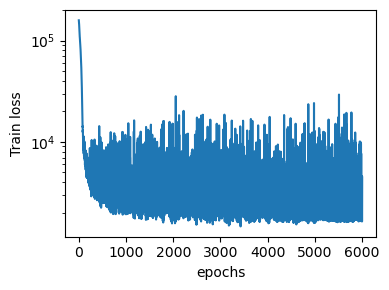

In [14]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.plot(model_history_df.epoch, model_history_df.train_loss)
ax.set_yscale('log')
ax.set_xlabel('epochs')
ax.set_ylabel('Train loss')
fig.tight_layout()
plt.show()

In [8]:
print(f'Train loss: {model_history_df.iloc[-1].train_loss}')
print(f'Test acc: {model_history_df.iloc[-1].test_acc}')
print(f'Test nll: {model_history_df.iloc[-1].test_nll}')

Train loss: 1739.2196044921875
Test acc: 0.6830999851226807
Test nll: 4.274302959442139


In [9]:
lr_0 = 1e-1
model = layers.RandomFeatureGaussianProcess(in_features=2048, out_features=10, rank=2048)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
setattr(model, 'linear', layers.VariationalLinear(model.linear, model.sigma_param))

model.lengthscale = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(math.sqrt(20)))))
torch.nn.utils.parametrize.register_parametrization(model, 'lengthscale', torch.nn.Softplus())
model.outputscale = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1.0))))
torch.nn.utils.parametrize.register_parametrization(model, 'outputscale', torch.nn.Softplus())

d = len(utils.flatten_params(model))
criterion = losses.DataEmphasizedELBo(d/len(train_dataset), model.sigma_param, criterion=torch.nn.CrossEntropyLoss())
optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.0, lr=lr_0, momentum=0.9, nesterov=True)


steps = 6000
num_batches = len(train_loader)
epochs = int(steps/num_batches)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*num_batches)

columns = ['epoch', 'train_acc', 'train_loss', 'train_nll', 'test_acc', 'test_loss', 'test_nll', 'val_acc', 'val_loss', 'val_nll']
model_history_df = pd.DataFrame(columns=columns)

for epoch in tqdm.tqdm(range(epochs)):
    train_metrics = utils.train_one_epoch(model, criterion, optimizer, train_and_val_loader, scheduler)
    #train_metrics = utils.train_one_epoch(model, criterion, optimizer, train_loader)
    val_metrics = {'acc': 0.0, 'loss': 0.0, 'nll': 0.0}
    test_metrics = {'acc': 0.0, 'loss': 0.0, 'nll': 0.0}

    if epoch == epochs-1:
        test_metrics = utils.evaluate(model, criterion, test_loader)
        val_metrics = utils.evaluate(model, criterion, val_loader)

    row = [epoch, train_metrics['acc'], train_metrics['loss'], train_metrics['nll'], test_metrics['acc'], test_metrics['loss'], test_metrics['nll'], val_metrics['acc'], val_metrics['loss'], val_metrics['nll']]
    model_history_df.loc[epoch] = row
    #print(model_history_df.iloc[epoch])
    

100%|██████████| 6000/6000 [03:32<00:00, 28.29it/s]


In [10]:
print(f'Lengthscale: {model.lengthscale}')
print(f'Outputscale: {model.outputscale}')

Lengthscale: 3.3810713291168213
Outputscale: 6.416886329650879


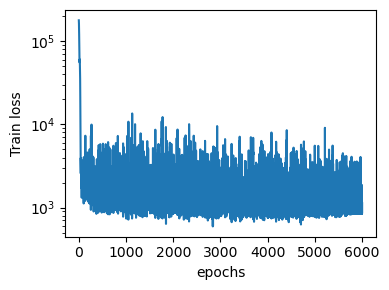

In [11]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.plot(model_history_df.epoch, model_history_df.train_loss)
ax.set_yscale('log')
ax.set_xlabel('epochs')
ax.set_ylabel('Train loss')
fig.tight_layout()
plt.show()

In [12]:
print(f'Train loss: {model_history_df.iloc[-1].train_loss}')
print(f'Test acc: {model_history_df.iloc[-1].test_acc}')
print(f'Test nll: {model_history_df.iloc[-1].test_nll}')

Train loss: 1128.415771484375
Test acc: 0.6524999737739563
Test nll: 1.6188340187072754
